## Global Open Science Electrophysiology

### 9. Causality and mediation tools for q-EEG and clinical applications

Tutorials created by Qing Wang (Vincent), all related materials regarding this tutorial are in this [GitHub Repo](https://github.com/Vincent-wq/causal_course_eeg).

In [1]:
# import libs used in this example
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import graphviz

import dowhy
from dowhy import CausalModel

from sklearn.linear_model import LassoCV
from sklearn.ensemble import GradientBoostingRegressor

print("dowhy version = ", dowhy.__version__)

/opt/conda/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/opt/conda/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


dowhy version =  0.11.1


### Example set up using qEEG as mediator for treatment effect of neuroEPO

Notice: This is a **simulation example** for tutorial purpose only using the clinical settings from the Maria's paper entitled [The Effect of Neuroepo on Cognition in Parkinson’s Disease Patients Is Mediated by Electroencephalogram Source Activity](https://www.frontiersin.org/journals/neuroscience/articles/10.3389/fnins.2022.841428/full).

#### The mediation model in the original paper is as follows:

![image](https://www.frontiersin.org/files/Articles/841428/fnins-16-841428-HTML-r1/image_m/fnins-16-841428-g001.jpg)




In [5]:
# Definition of graph
import matplotlib.pyplot as plt
import networkx as nx
from io import StringIO
# Read the GML graph
from networkx.drawing.nx_pydot import graphviz_layout

def graph_init(DIRECTED, node_list, node_label_list, edge_list, edge_weight_lsit ):
    # Construct the graph (the graph is constant for all iterations)
    # Direction
    if DIRECTED:
        gml_string = 'graph [directed 1\n'
    else:
        gml_string = 'graph [directed 0\n'

    # Generate the GML graph
    for i_node in range(len(node_list)):
        gml_string += f'\tnode [id "{node_list[i_node]}" label "{node_label_list[i_node]}"]\n'
    # Generate edges
    for i_edge in range(len(edge_list)):
        gml_string += f'\tedge [source "{edge_list[i_edge][0]}" target "{edge_list[i_edge][1]}"]\n'
    
    gml_string += ']'

    return gml_string

In [6]:
# First, we'll build the ground truth causal structure, i.e. structrual causal model (SCM)

class neuroEPO_SCM:
    def __init__(self, random_seed=None):
        self.random_seed = random_seed
        self.u_x = stats.truncnorm(0, np.infty, scale=4)
        self.u_y = stats.norm(scale=2)
        self.u_z = stats.norm(scale=2)
        self.u = stats.truncnorm(0, np.infty, scale=4)
        
    def sample(self, sample_size=100, treatment_value=None):
        """Samples from the SCM"""
        if self.random_seed:
            np.random.seed(self.random_seed)
        
        u_x = self.u_x.rvs(sample_size)
        u_y = self.u_y.rvs(sample_size)
        u_z = self.u_z.rvs(sample_size)
        u = self.u.rvs(sample_size)
        
        if treatment_value:
            x_ = np.array([treatment_value]*sample_size)
        else:
            x_ = u_x + 0.7*u

        # Creating the Golden standard model   
        m_ = -0.6*x_ + 0.25*u_z
        y_ =  1.0*m_ + 0.9*x_ + 0.25*u
        
        # 
        nodes_list = ['X', 'M', 'Y', 'U']
        nodes_label__list = ['neuroEPO', 'qEEG', 'Cognition', 'Education']

        link_list   = ['XM', 'MY', 'XY', 'UY']
        link_weight = [-0.6,  1.0,  0.9, 0.25]

        model_str = graph_init(1, nodes_list, nodes_label__list, link_list, link_weight)
        
        return x_, m_, y_, u, model_str
    
    def intervene(self, treatment_value, sample_size=100):
        """Intervenes on the SCM"""
        return self.sample(treatment_value=treatment_value, sample_size=sample_size)

,neuroEPO,qEEG,Cognition,Education
0,6.099636,-3.965802,3.676069,8.608795
1,4.900190,-2.219996,2.284907,0.378930
2,5.239434,-3.062413,2.620116,3.868152
3,2.697559,-1.270238,1.280000,0.489738
4,1.215006,-1.185199,0.334946,1.706558


The graphical model specified:


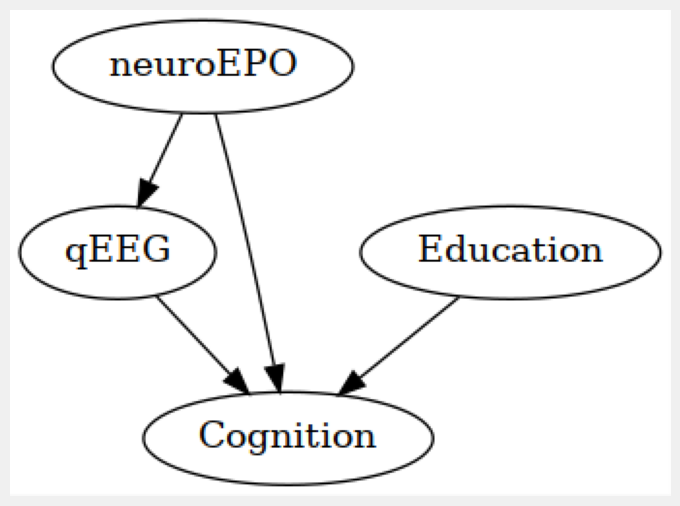

In [11]:
# Instantiate the SCM
scm = neuroEPO_SCM(random_seed = 0)

# Generate observational data
neuro_EPO_obv, qEEG_obv, cognition_obv, factor1_obv, model_gt = scm.sample(1000)

# Encode as a pandas df
df = pd.DataFrame(np.vstack([neuro_EPO_obv, qEEG_obv, cognition_obv, factor1_obv]).T, columns=['neuroEPO', 'qEEG', 'Cognition', 'Education'])
display(df.head(5))

# define the model
model = CausalModel(
    data=df,
    treatment='neuroEPO',
    outcome='Cognition',
    common_causes = 'Education',
    graph=model_gt
)
print("The graphical model specified:")

model.view_model()
#gml_file_like = StringIO(neuroEPO_graph)

In [13]:
# estimand
estimand = model.identify_effect()
print(estimand)

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
     d                   
───────────(E[Cognition])
d[neuroEPO]              
Estimand assumption 1, Unconfoundedness: If U→{neuroEPO} and U→Cognition then P(Cognition|neuroEPO,,U) = P(Cognition|neuroEPO,)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



In [14]:
estimate = model.estimate_effect(
    identified_estimand=estimand,
    method_name='backdoor.linear_regression')
print(f'Estimate of causal effect (linear regression): {estimate.value}')

Estimate of causal effect (linear regression): 0.33499088452890213


/opt/conda/lib/python3.9/site-packages/dowhy/causal_estimator.py:236: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  by_effect_mods = data.groupby(effect_modifier_names)
/opt/conda/lib/python3.9/site-packages/dowhy/causal_estimators/regression_estimator.py:179: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]
/opt/conda/lib/python3.9/site-packages/dowhy/causal_estimators/regression_estimator.py:179: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior

#### Refutation test1: What will the results be if we only have less data?

In [40]:
refute_subset = model.refute_estimate(
    estimand=estimand, 
    estimate=estimate,
    method_name="data_subset_refuter", 
    subset_fraction=0.4)

print(refute_subset)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please cha

Refute: Use a subset of data
Estimated effect:0.6910074783952967
New effect:0.704928489626013
p value:0.8200000000000001



A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Refute: Use a subset of data
Estimated effect:0.33499088452890213
New effect:0.3342692898971237
p value:0.86



### Example: How will the sample size affect our causal estimate?

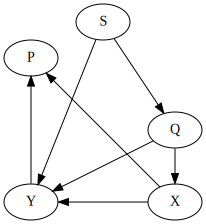

In [18]:
graph = graphviz.Digraph(engine='neato')
nodes = ['S', 'Q', 'X', 'Y', 'P']
positions = ['2,2.5!', '3,1!', '3,0!', '1, 0!', '1,2!', '1.7,0.9!']
edges = ['SQ', 'SY', 'QX', 'QY', 'XP', 'YP', 'XY']

[graph.node(n, pos=pos) for n, pos in zip(nodes, positions)]
graph.edges(edges)
graph.render(f'img/example')
graph

In [21]:
SAMPLE_SIZE = 1000

S = np.random.random(SAMPLE_SIZE)
Q = 0.2*S + 0.67*np.random.random(SAMPLE_SIZE)
X = 0.14*Q + 0.4*np.random.random(SAMPLE_SIZE)
Y = 0.7*X + 0.11*Q + 0.32*S + 0.24*np.random.random(SAMPLE_SIZE)
P = 0.43*X + 0.21*Y + 0.22*np.random.random(SAMPLE_SIZE)

# Encode as a pandas df
df = pd.DataFrame(np.vstack([S, Q, X, Y, P]).T, columns=['S', 'Q', 'X', 'Y', 'P'])

In [22]:
# Generate the GML graph
gml_string = 'graph [directed 1\n'
for node in nodes:
    gml_string += f'\tnode [id "{node}" label "{node}"]\n'
for edge in edges:
    gml_string += f'\tedge [source "{edge[0]}" target "{edge[1]}"]\n'
gml_string += ']'

print(gml_string)

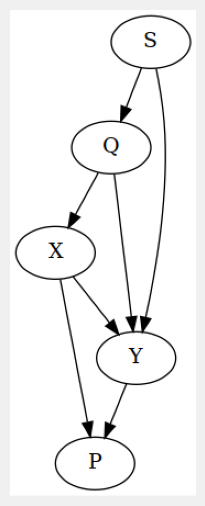

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
 d          
────(E[Y|Q])
d[X]        
Estimand assumption 1, Unconfoundedness: If U→{X} and U→Y then P(Y|X,Q,U) = P(Y|X,Q)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



In [27]:
# Instantiate the CausalModel 
model = CausalModel(
    data=df,
    treatment='X',
    outcome='Y',
    graph=gml_string
)

# Visualize the model
model.view_model()
# Get the estimand
estimand = model.identify_effect()
print(estimand)

In [26]:
estimate = model.estimate_effect(
    identified_estimand=estimand,
    method_name='backdoor.econml.dml.DML',
    method_params={
        'init_params': {
            'model_y': GradientBoostingRegressor(),
            'model_t': GradientBoostingRegressor(),
            'model_final': LassoCV(fit_intercept=False),
        },
        'fit_params': {}}
)

print(f'Estimate of causal effect (DML): {estimate.value}')

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Estimate of causal effect (DML): 0.6910074783952967


In [20]:
estimate_lr = model.estimate_effect(
    identified_estimand=estimand,
    method_name='backdoor.linear_regression')

print(f'Estimate of causal effect (linear regression): {estimate_lr.value}')

Estimate of causal effect (linear regression): 0.6858784883704395


In [28]:
random_cause = model.refute_estimate(
    estimand=estimand, 
    estimate=estimate,
    method_name='random_common_cause'
)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please cha

In [29]:
print(random_cause)

Refute: Add a random common cause
Estimated effect:0.6910074783952967
New effect:0.7023877344728372
p value:0.48



In [30]:
placebo_refuter = model.refute_estimate(
    estimand=estimand, 
    estimate=estimate,
    method_name='placebo_treatment_refuter'
)

AttributeError: 'NoneType' object has no attribute 'startswith'

In [24]:
print(placebo_refuter)

Refute: Use a Placebo Treatment
Estimated effect:0.6528130665938017
New effect:0.0
p value:1.0



In [32]:
import networkx as nx
from dowhy import gcm

In [33]:
SAMPLE_SIZE = 1000

S = np.random.random(SAMPLE_SIZE)
Q = 0.2*S + 0.67*np.random.random(SAMPLE_SIZE)
X = 0.14*Q + 0.4*np.random.random(SAMPLE_SIZE)
Y = 0.7*X + 0.11*Q + 0.32*S + 0.24*np.random.random(SAMPLE_SIZE)
P = 0.43*X + 0.21*Y + 0.22*np.random.random(SAMPLE_SIZE)

# Encode as a pandas df
df = pd.DataFrame(np.vstack([S, Q, X, Y, P]).T, columns=['S', 'Q', 'X', 'Y', 'P'])

In [34]:
edges = ['SQ', 'SY', 'QX', 'QY', 'XP', 'YP', 'XY']
graph_nx = nx.DiGraph([(edge[0], edge[1]) for edge in edges])

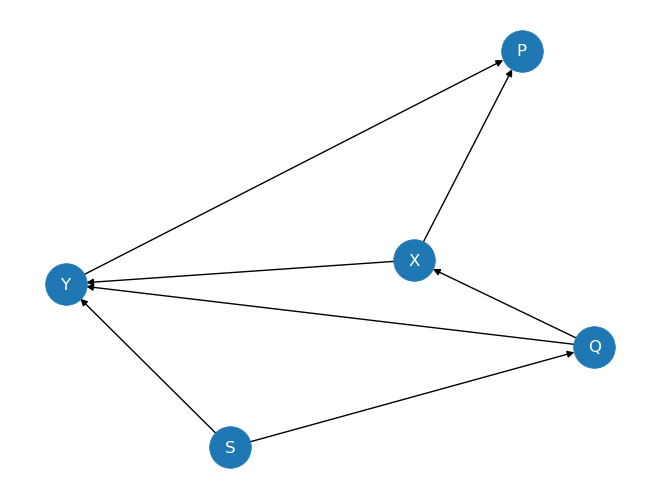

In [35]:
nx.draw(
    graph_nx, 
    with_labels=True, 
    node_size=900,
    font_color='white', 
)

In [36]:
causal_model = gcm.InvertibleStructuralCausalModel(graph_nx)

In [37]:
causal_model.set_causal_mechanism('S', gcm.EmpiricalDistribution())
causal_model.set_causal_mechanism('X', gcm.AdditiveNoiseModel(gcm.ml.create_linear_regressor()))
causal_model.set_causal_mechanism('Y', gcm.AdditiveNoiseModel(gcm.ml.create_linear_regressor()))
causal_model.set_causal_mechanism('P', gcm.AdditiveNoiseModel(gcm.ml.create_linear_regressor()))
causal_model.set_causal_mechanism('Q', gcm.AdditiveNoiseModel(gcm.ml.create_linear_regressor()))

gcm.fit(causal_model, df)

Fitting causal mechanism of node P: 100%|██████████| 5/5 [00:00<00:00, 195.37it/s]


In [38]:
gcm.arrow_strength(causal_model, 'Y')

/opt/conda/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/opt/conda/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/opt/conda/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


{('Q', 'Y'): 0.0005828543780590882,
 ('S', 'Y'): 0.008767186030080172,
 ('X', 'Y'): 0.006453398433224654}

In [39]:
gcm.counterfactual_samples(
    causal_model,
    {'X': lambda x: .21},
    observed_data=pd.DataFrame(data=dict(X=[.5], Y=[.75], S=[.5], Q=[.4], P=[.34])))

,S,Q,X,Y,P
0,0.5,0.4,0.21,0.547671,0.168176
